In [7]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm, trange
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, roc_auc_score, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

In [8]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate, Input, concatenate, Activation
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [9]:
# load the files
houselist = glob.glob('HousesDataset/*.jpg')

image_data = []
for fname in houselist:
    image_name = fname.split('\\')[1].split('.')[0]
    image_data.append((image_name, Image.open(fname)))
    pass

text_data = pd.read_csv('HousesDataset/HousesInfo.txt', sep=' ',
                        names=["nBeds", "nbaths", "area", "zipcode", "price"])

row, col = 200, 200
X11 = np.zeros((535, row, col, 3)).astype(int)
X12 = np.zeros((535, row, col, 3)).astype(int)
X13 = np.zeros((535, row, col, 3)).astype(int)
X14 = np.zeros((535, row, col, 3)).astype(int)
for name, image in tqdm(image_data):
    index, room = name.split('_')
    if room == "bathroom":
        X11[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "bedroom":
        X12[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "frontal":
        X13[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    else:
        X14[int(index) - 1, :, :] = np.array(image.resize((row, col)))

100%|█████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:17<00:00, 121.16it/s]


In [10]:
zipcodes = text_data["zipcode"].value_counts().keys().tolist()
counts = text_data["zipcode"].value_counts().tolist()

zipcode_rm_list = []
for (zipcode, count) in zip(zipcodes, counts):
    if count < 20 and zipcode not in zipcode_rm_list:
        zipcode_rm_list.append(zipcode)

text_array = np.zeros((535, 5))
for i, text in text_data.iterrows():
    text_array[i] = text.values
        
keep_index = []
for i in range(len(text_array)):
    if text_array[i][3] not in zipcode_rm_list:
        keep_index.append(i)

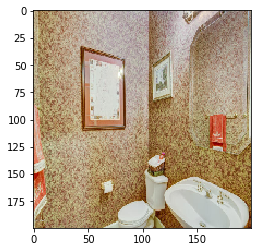

In [11]:
plt.imshow(X11[0])

In [30]:
text_array_clean = text_array[keep_index]
X11_clean = X11[keep_index]
X12_clean = X12[keep_index]
X13_clean = X13[keep_index]
X14_clean = X14[keep_index]

#categorize the zipcode data
zipBinarizer = LabelBinarizer().fit(text_array_clean[:, 3])
zip_categorical = zipBinarizer.transform(text_array_clean[:, 3])

X2_clean = np.hstack([text_array_clean[:, :3], zip_categorical])
y = text_array_clean[:, -1]
y_class_clean = np.where(y > 700000, 1, 0)

In [49]:
shuffle = np.arange(len(y))
np.random.shuffle(shuffle)

X11_clean = X11_clean[shuffle]
X12_clean = X12_clean[shuffle]
X13_clean = X13_clean[shuffle]
X14_clean = X14_clean[shuffle]
X2_clean = X2_clean[shuffle]
y_class_clean = y_class_clean[shuffle]

split_inedx = 320

x11_train = X11_clean[:split_inedx]
x12_train = X12_clean[:split_inedx]
x13_train = X13_clean[:split_inedx]
x14_train = X14_clean[:split_inedx]
x2_train = X2_clean[:split_inedx]
y_train = y_class_clean[:split_inedx]

x11_test = X11_clean[split_inedx:]
x12_test = X12_clean[split_inedx:]
x13_test = X13_clean[split_inedx:]
x14_test = X14_clean[split_inedx:]
x2_test = X2_clean[split_inedx:]
y_test = y_class_clean[split_inedx:]

# x2_min = np.min(x2_train, axis=0)
# x2_max = np.max(x2_train, axis=0)
# x2_train = (x2_train - x2_min) / (x2_max - x2_min)
# x2_test = (x2_test - x2_min) / (x2_max - x2_min)

In [50]:
# cnn model
def visual_model(input_layer):
    conv1 = Conv2D(8, kernel_size=(3, 3), activation='relu')(input_layer)
    bat1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bat1)
    conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')(pool1)
    bat2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(3, 3))(bat2)
    conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')(pool2)
    bat3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bat3)
    flat = Flatten()(pool3)
    x = Dense(16)(flat)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4)(x)
    x = Activation("sigmoid")(x)
    return x

In [51]:
def merged_model():
    # visual features (cnn)
    visual_input1 = Input(shape=(row, col, 3), name='visual_input1')
    visual1 = visual_model(visual_input1)

    visual_input2 = Input(shape=(row, col, 3), name='visual_input2')
    visual2 = visual_model(visual_input2)

    visual_input3 = Input(shape=(row, col, 3), name='visual_input3')
    visual3 = visual_model(visual_input3)

    visual_input4 = Input(shape=(row, col, 3), name='visual_input4')
    visual4 = visual_model(visual_input4)

    # textual features (mlp)
    textual_input = Input(shape=(11,), name='textual_input')
    textual_output = Dense(20, activation='relu')(textual_input)
    textual_output = BatchNormalization()(textual_input)

    # merge visual and textual layers
    x = keras.layers.concatenate([visual1, visual2, visual3, visual4, textual_output])
    # fully connectied
    x = Dense(10, activation='relu')(x)
    x = Dropout(0.5)(x)

    # output
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[visual_input1, visual_input2, visual_input3, visual_input4, textual_input], outputs=main_output)
    return model

In [72]:
y_hat = []
y_val_list = []


for i in range(5):
    print("Training on Fold: ",i+1)
    x11_tr,x11_val, x12_tr, x12_val, x13_tr, x13_val, x14_tr, x14_val, x2_tr, x2_val, y_tr, y_val = train_test_split(
        x11_train, x12_train, x13_train, x14_train, x2_train, y_train, test_size=0.33, random_state=42)
    
    model = merged_model()
    model.compile(optimizer="adam",
                  loss={'main_output': 'binary_crossentropy'}, metrics={'main_output': ["accuracy"]})

    model.fit([x11_tr, x12_tr, x13_tr, x14_tr, x2_tr], y_tr,
              shuffle=True,
              epochs=40, 
              batch_size=100)
    
    y_hat.append(model.predict([x11_val, x12_val, x13_val, x14_val, x2_val]))
    y_val_list.append(y_val)
    
    metric = model.evaluate([x11_val, x12_val, x13_val, x14_val, x2_val], y_val)
    print("Val loss: {0}, Val acc: {1}".format(metric[0], metric[1]))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/40
214/214 [==============================] - 65s 301ms/step - loss: 1.3582 - acc: 0.2944
Epoch 2/40
214/214 [==============================] - 1s 6ms/step - loss: 1.2241 - acc: 0.3364
Epoch 3/40
214/214 [==============================] - 1s 6ms/step - loss: 1.1511 - acc: 0.3224
Epoch 4/40
214/214 [==============================] - 1s 6ms/step - loss: 1.1390 - acc: 0.3271
Epoch 5/40
214/214 [==============================] - 1s 6ms/step - loss: 1.1154 - acc: 0.3458
Epoch 6/40
214/214 [==============================] - 1s 6ms/step - loss: 1.0412 - acc: 0.3551
Epoch 7/40
214/214 [==============================] - 1s 6ms/step - loss: 1.0365 - acc: 0.3879
Epoch 8/40
214/214 [==============================] - 1s 6ms/step - loss: 0.9229 - acc: 0.4720
Epoch 9/40
214/214 [==============================] - 1s 6ms/step - loss: 0.9180 - acc: 0.4439
Epoch 10/40
214/214 [==============================] - 1s 6ms/step - loss: 0.8585 - acc: 0.4346
Epoch 11/40
214/214 [====

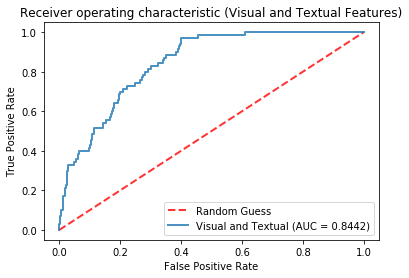

In [80]:
# combine k folds
y_hat_total = np.concatenate(y_hat)
y_val_total = np.concatenate(y_val_list)

fpr, tpr, thresholds = roc_curve(y_val_total, y_hat_total)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

plt.plot(fpr, tpr,
         label='Visual and Textual (AUC = {:.4})'.format(roc_auc),
         lw=2, alpha=.8)

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Visual and Textual Features)')
plt.show()

In [81]:
# actual model
model = merged_model()
model.compile(optimizer="adam",
              loss={'main_output': 'binary_crossentropy'}, metrics={'main_output': ["accuracy"]})

model.fit([x11_train, x12_train, x13_train, x14_train, x2_train], y_train,
          shuffle=True,
          epochs=40, 
          batch_size=100)

Epoch 1/40
320/320 [==============================] - 81s 252ms/step - loss: 0.7753 - acc: 0.5375
Epoch 2/40
320/320 [==============================] - 2s 6ms/step - loss: 0.6868 - acc: 0.5906
Epoch 3/40
320/320 [==============================] - 2s 6ms/step - loss: 0.6652 - acc: 0.6312
Epoch 4/40
320/320 [==============================] - 2s 6ms/step - loss: 0.6398 - acc: 0.6781
Epoch 5/40
320/320 [==============================] - 2s 6ms/step - loss: 0.5930 - acc: 0.7062
Epoch 6/40
320/320 [==============================] - 2s 6ms/step - loss: 0.5889 - acc: 0.7406
Epoch 7/40
320/320 [==============================] - 2s 6ms/step - loss: 0.5501 - acc: 0.7469
Epoch 8/40
320/320 [==============================] - 2s 6ms/step - loss: 0.5233 - acc: 0.7781
Epoch 9/40
320/320 [==============================] - 2s 6ms/step - loss: 0.4967 - acc: 0.7781
Epoch 10/40
320/320 [==============================] - 2s 6ms/step - loss: 0.5187 - acc: 0.7563
Epoch 11/40
320/320 [=========================

In [82]:
y_hat = model.predict([x11_test, x12_test, x13_test, x14_test, x2_test])

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
print("roc: ", roc_auc_score(y_test, y_hat))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("threshold: ", optimal_threshold)

roc:  0.7984981226533165
threshold:  0.20805314


In [87]:
index = 0
for y1, y2 in zip(y_class[split_inedx:], np.where(y_hat.ravel() > optimal_threshold, 1, 0)):
    print("{}th, ".format(index), "y: ",y1, ", y_hat: ", y2)
    index += 1

0th,  y:  0 , y_hat:  0
1th,  y:  0 , y_hat:  1
2th,  y:  1 , y_hat:  0
3th,  y:  0 , y_hat:  0
4th,  y:  0 , y_hat:  0
5th,  y:  0 , y_hat:  0
6th,  y:  0 , y_hat:  0
7th,  y:  0 , y_hat:  0
8th,  y:  0 , y_hat:  0
9th,  y:  0 , y_hat:  0
10th,  y:  1 , y_hat:  0
11th,  y:  0 , y_hat:  0
12th,  y:  0 , y_hat:  0
13th,  y:  0 , y_hat:  0
14th,  y:  1 , y_hat:  0
15th,  y:  1 , y_hat:  0
16th,  y:  0 , y_hat:  1
17th,  y:  1 , y_hat:  1
18th,  y:  0 , y_hat:  0
19th,  y:  0 , y_hat:  1
20th,  y:  0 , y_hat:  0
21th,  y:  0 , y_hat:  0
22th,  y:  0 , y_hat:  1
23th,  y:  1 , y_hat:  1
24th,  y:  0 , y_hat:  0
25th,  y:  0 , y_hat:  0
26th,  y:  0 , y_hat:  0
27th,  y:  0 , y_hat:  0
28th,  y:  0 , y_hat:  1
29th,  y:  0 , y_hat:  0
30th,  y:  0 , y_hat:  0
31th,  y:  1 , y_hat:  0
32th,  y:  0 , y_hat:  0
33th,  y:  0 , y_hat:  0
34th,  y:  0 , y_hat:  1
35th,  y:  0 , y_hat:  0
36th,  y:  0 , y_hat:  0
37th,  y:  1 , y_hat:  0
38th,  y:  0 , y_hat:  0
39th,  y:  0 , y_hat:  1
40th,  y: 

In [119]:
def plot_house(house_i, title):
    plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.imshow(x11_test[house_i])
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(x12_test[house_i])
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(x13_test[house_i])
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(x14_test[house_i])
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

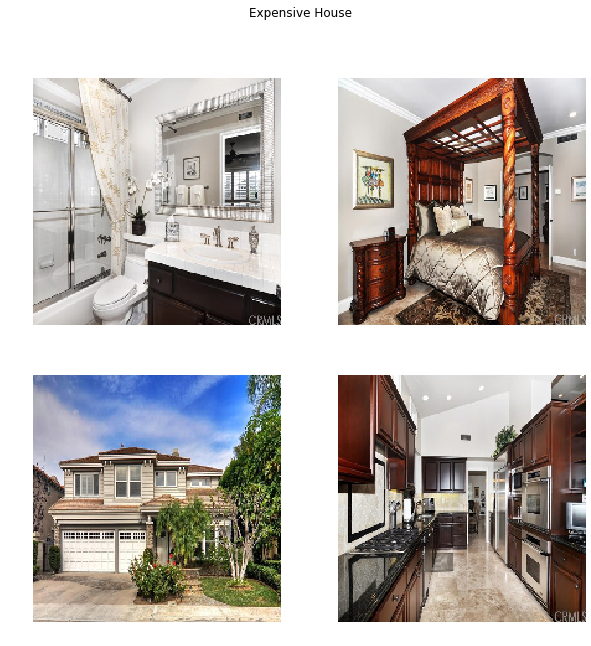

In [120]:
plot_house(23, 'Expensive House')

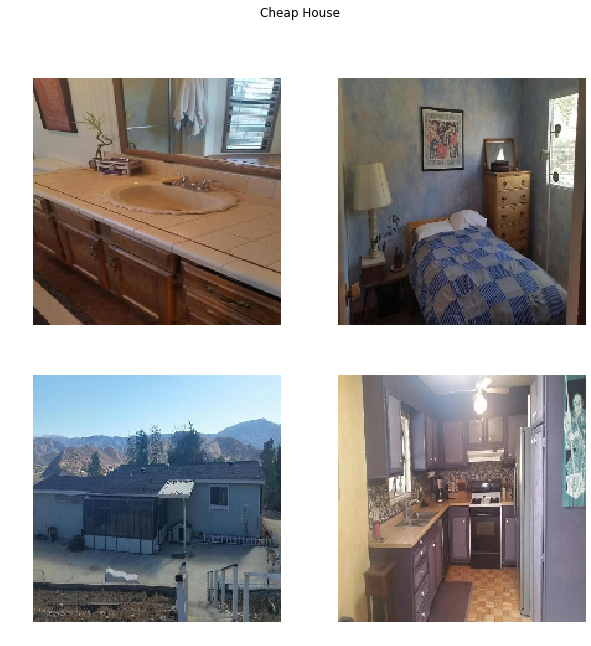

In [121]:
plot_house(4, "Cheap House")